<a href="https://colab.research.google.com/github/vitor-rc/distributed-generation-penetration-impacts/blob/main/TCC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando pacotes e preparando o ambiente

In [ ]:
!pip install pandapower
!pip install --upgrade gspread

from google.colab import auth
auth.authenticate_user()

Requirement already up-to-date: gspread in /usr/local/lib/python3.6/dist-packages (3.6.0)


In [ ]:
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Importando bibliotecas necessárias

In [ ]:
import pandapower as pp
import pandas as pd
import pandapower.networks as nw
import pandapower.plotting as plot
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import scipy.io

# Importar a rede de estudo

In [ ]:
#net = nw.ieee_european_lv_asymmetric('off_peak_1')
net = nw.ieee_european_lv_asymmetric('on_peak_566')
#net = nw.ieee_european_lv_asymmetric('off_peak_1440')

# indice de penetracao
IP=0.6

# A Partir Daqui são definidas as funções usadas no problemas

In [ ]:
def plot_network():
    try:
        import seaborn
        colors = seaborn.color_palette()
    except:
        colors = ["b", "g", "r", "c", "y"]
    %matplotlib inline

    # Plot all the buses
    bc = plot.create_bus_collection(net, net.bus.index, size=.2, color=colors[0], zorder=10)

    #Plot Transformers
    tlc, tpc = plot.create_trafo_collection(net, net.trafo.index, color="g",size =1.5 )

    # Plot all the lines
    lcd = plot.create_line_collection(net, net.line.index, color="grey", linewidths=0.5, use_bus_geodata=True)

    # Plot the external grid
    sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="poly3", size=1, color="c", zorder=11)

    #Plot all the loads
    ldA = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_a_mw >0)], patch_type="poly3", size=.5, color="r", zorder=11)
    ldB = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_b_mw >0)], patch_type="rect", size=.5, color="y", zorder=11)
    ldC = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_c_mw >0)], patch_type="circle", size=.5, color="b", zorder=11)

    # Plot the max. loaded line and max. unbalanced node
    max_load = plot.create_line_collection(net, np.array([net.res_line_3ph.loading_percent.idxmax()]), color="black", linewidths=15, use_bus_geodata=True)
    max_unbal = plot.create_bus_collection(net, np.array([net.res_bus_3ph.unbalance_percent.idxmax()]), patch_type="rect", size=1, color="black", zorder=11)

    # Draw all the collected plots
    plot.draw_collections([lcd, bc, tlc, tpc, sc,ldA,ldB,ldC,max_load,max_unbal], figsize=(20,20))
    
# plot_network()

The number of given colors (1) is smaller than the number of nodes (907) to draw! The colors will be repeated to fit.


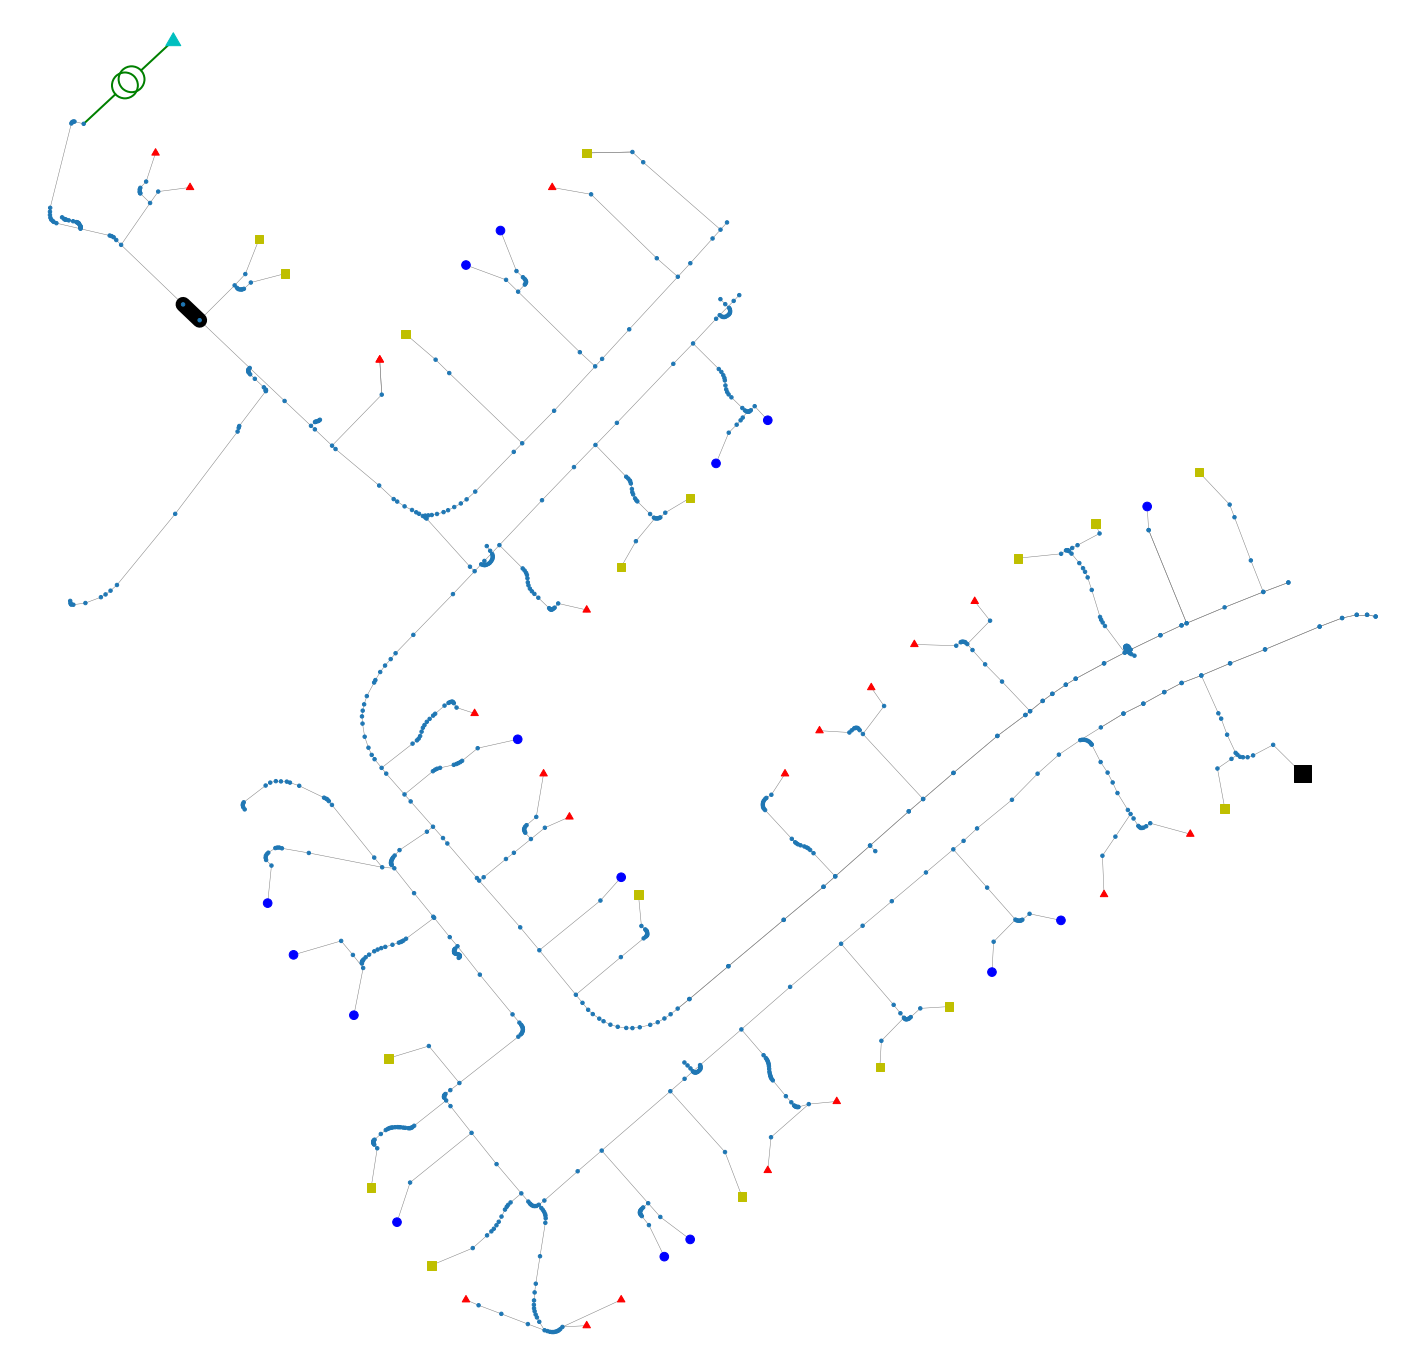

In [ ]:
plot_network()

In [ ]:
#r_cap = pd.read_csv('/content/drive/My Drive/TCC_2020/Matlab_legacy/Mestrado_Marina/Resid_2018_06_30_database2.csv',header=0)
# Read source file with installed capacities information

Resid_2018_06_30_database2 = gc.open_by_key('1DhTztu3fBIn6-2viEA_ygPwIKlgyh18wtEh9o_0JDO0').get_worksheet(0)
r_cap = pd.DataFrame(Resid_2018_06_30_database2.col_values(1))


#r_cap.at[3,"resid_cap_vals"]
r_cap = r_cap.drop([0])
r_cap[0] = pd.to_numeric(r_cap[0])
# r_cap

In [ ]:
def Allocate_PV(Transformer_capacity, Penetration_index, Nb_Load):

  Total_PV_cap = Transformer_capacity*Penetration_index/100

  #Select maximum installed capacity (in kWp)
  max_cap = 15

  cap = []
  for i in range(1,len(r_cap)+1,1):
    if (r_cap.at[i,0]<= max_cap): # Pega apenas os valores de PV menores que o valor max_cap
        cap.append(r_cap.at[i,0])
        
  #Sturges rule
  n_bins = 1 + 3.322*(math.log(len(cap))/math.log(10))
  n_bins = round(n_bins)
  n_bins *= 2

  # Generating histogram from actual installed capacity data
  (n, bins) = np.histogram(cap,bins=n_bins)
  h_edges = bins
  h_val = n

  #Getting the installed capacities to be randomly sorted
  PV_cap = []
  for i in range(0,len(h_edges)-1,1):
    PV_cap.append( (h_edges[i]+h_edges[i+1])/2 )

  # Assembling CDF of installed capacities
  kwp_cdf = []
  for i in range(1,len(PV_cap)+1,1):
      kwp_cdf.append( sum(h_val[0:i])/sum(h_val) )

  # Getting the installed capacity for each PV system
  Total_cap = 0;
  Nb_PV =1;
  
  sorted_Cap = []
  while Total_cap <= Total_PV_cap:
      kk=1
      sort = random.random()
      while sort > kwp_cdf[kk]: #Achar o kk que representa em que ponto do histograma acumulado está o número sorteado
          kk=kk+1
      
      if Nb_PV<=Nb_Load:
          sorted_Cap.append(PV_cap[kk-1]) #confirmar
          Total_cap = Total_cap + sorted_Cap[-1] #confirmar
      else:
          x = random.randint(1,Nb_Load-1) 
          sorted_Cap[x] = sorted_Cap[x]+PV_cap[kk-1]
          Total_cap = Total_cap + PV_cap[kk-1]
        
      Nb_PV=Nb_PV+1

  Total_cap
  Nb_PV = len(sorted_Cap)
  PV_location=[]
  # sorting the location of the Nb_PV systems
  for i in range(0,Nb_PV,1):
      aux=np.random.choice(np.arange(1,Nb_Load))
      PV_location.append( aux)  
  #sorted_Cap = 0
  #PV_location = 0
  #Nb_PV = 0
  return (sorted_Cap, PV_location, Nb_PV)
# Allocate_PV(Transformer_capacity=880, Penetration_index=20, Nb_Load=55)

In [ ]:
Curvas_extraidas = gc.open_by_key('1QoDRqg0pOoEJ2diETBuhl1k_IaBOakuVQfUQG2t4jg0')

x1 = pd.DataFrame(Curvas_extraidas.worksheet('Deviation').col_values(1)) #hora
DP = pd.DataFrame(Curvas_extraidas.worksheet('Deviation').col_values(2)) #Desvio Padrao
x1 = x1.drop([0])
x1[0] = x1[0].str.replace(",", ".").astype(float)
DP = DP.drop([0])
DP[0] = DP[0].str.replace(",", ".").astype(float)

x2 = pd.DataFrame(Curvas_extraidas.worksheet('Mean').col_values(1))
perfil = pd.DataFrame(Curvas_extraidas.worksheet('Mean').col_values(2))
x2[0] = x2[0].str.replace(",", ".").astype(float)
perfil[0] = perfil[0].str.replace(",", ".").astype(float)


In [ ]:
# Função Desvio Padrão 
def Desvio_Padrao(t0, tf, ss_res):
    t0;  tf;  ss_res 
    td= np.arange(0,24,ss_res/60)

    Curvas_extraidas = gc.open_by_key('1QoDRqg0pOoEJ2diETBuhl1k_IaBOakuVQfUQG2t4jg0')
    x1 = pd.DataFrame(Curvas_extraidas.worksheet('Deviation').col_values(1)) #hora
    DP = pd.DataFrame(Curvas_extraidas.worksheet('Deviation').col_values(2)) #Desvio Padrao
    x1 = x1.drop([0])
    x1[0] = x1[0].str.replace(",", ".").astype(float)
    DP = DP.drop([0])
    DP[0] = DP[0].str.replace(",", ".").astype(float)
    DP=DP.to_numpy().transpose()
    time = x1.to_numpy().transpose()
    t1 = np.nonzero(td==t0)[0][0]
    t2 = np.nonzero(td==tf)[0][0]

    c = scipy.interpolate.splrep(time[0],DP[0],s=0)
    DP_t1t2 = scipy.interpolate.splev(td[t1:t2], c, der=0)
    #DP=spline(time,DP,td(t1:t2)) # Cubic spline data interpolation

    return DP_t1t2

In [ ]:
# Função Perfil de Carga
def Perfil_de_Carga(t0, tf, ss_res):
    t0;tf; ss_res
    # td= [0:ss_res/60:24]; 
    td = np.arange(0,24,ss_res/60)
    Curvas_extraidas = gc.open_by_key('1QoDRqg0pOoEJ2diETBuhl1k_IaBOakuVQfUQG2t4jg0')
    x2 = pd.DataFrame(Curvas_extraidas.worksheet('Mean').col_values(1))
    perfil = pd.DataFrame(Curvas_extraidas.worksheet('Mean').col_values(2))
    
    x2 = x2.drop([0])
    x2[0] = x2[0].str.replace(",", ".").astype(float)
    
    perfil = perfil.drop([0])
    perfil[0] = perfil[0].str.replace(",", ".").astype(float)
    
    perfil=perfil.to_numpy().transpose()


    time1 = x2.to_numpy().transpose()
    t1 = np.nonzero(td==t0)[0][0]
    t2 = np.nonzero(td==tf)[0][0]  

    #PC = spline(time1,perfil,td(t1:t2));
    d = scipy.interpolate.splrep(time1[0],perfil[0],s=0)
    PC = scipy.interpolate.splev(td[t1:t2], d, der=0)
    return PC


# Código principal com as variáveis do problema e o loop de Monte Carlo

In [ ]:
#net = nw.ieee_european_lv_asymmetric('off_peak_1')
net = nw.ieee_european_lv_asymmetric('on_peak_566')
#net = nw.ieee_european_lv_asymmetric('off_peak_1440')

# Define Snapshot Resolution
ss_res = 15; # in minutes

# Define Number of hours of simulation
t0=1
tf=23
Nb_h = tf-t0

Transformer_capacity = 800
Penetration_index = 80

# Calculate the number of snapshots Nb_ss
Nb_ss = Nb_h*60/ss_res+1
Nb_ss=int(Nb_ss)
#if Penetration_index ~= 0
      
# Load profile

P_inst = 15
pf= 1

Std_load = Desvio_Padrao(t0, tf, ss_res)
Avg_load = Perfil_de_Carga(t0, tf, ss_res)

#base = xlsread('Cargamediabase.xlsx')
Cargamediabase = gc.open_by_key('1iI3d8zT_uc4HTmHmIdHPWYaoFvVmdkgKFTmLQreN2D8')
base = pd.DataFrame(Cargamediabase.worksheet('Plan1').col_values(1))
base = base.drop([0])
base[0] = base[0].str.replace(",", ".").astype(float)

#disp('Parameters of the simulation are defined.')

#tic # Contador de tempo

MCM=0 # Contador do numero de simulacoes

# Criterio de parada inicializacao
stop_crita = 1
stop_critb = 1
stop_critc = 1

erroa = np.zeros((1,2))
errob= np.zeros((1,2))
erroc= np.zeros((1,2))
# Determinam o limite das barras no histograma
#edges = 0.8:0.02:1.2
edges = np.arange(0,151,1)
# Erro relativo 
sensivity = 1/1000
Nb_line=len(net.line)
Load_Ia=np.zeros((1,Nb_line,Nb_ss-1))
Load_Ib=np.zeros((1,Nb_line,Nb_ss-1))
Load_Ic=np.zeros((1,Nb_line,Nb_ss-1))
while (stop_crita>=sensivity or stop_critb>=sensivity or stop_critc>=sensivity):
    
    print (MCM)
    net_prim = nw.ieee_european_lv_asymmetric('on_peak_566')
    net=net_prim
    Load_Ia=np.concatenate((Load_Ia,[np.zeros((Nb_line,Nb_ss-1))]),0)
    Load_Ib=np.concatenate((Load_Ib,[np.zeros((Nb_line,Nb_ss-1))]),0)
    Load_Ic=np.concatenate((Load_Ic,[np.zeros((Nb_line,Nb_ss-1))]),0)

    Nb_Load = len(net.asymmetric_load) # numero de cargas
    
    #%% Create load profiles 
    Load_kW=np.zeros((Nb_Load,int(Nb_ss)-1))  
    for i in range(0,Nb_Load):
        for j in range(0,int(Nb_ss)-1): #number of snapshots
            Load_kW[i][j] = (Avg_load[j] + Std_load[j]*random.random())*base[0][i+1]
    #print(Load_kW)
    print('Load profiles created successfully')
   
    ## Create PV systems
    
    if (Penetration_index != 0): 
      sorted_Cap, PV_location, Nb_PV = Allocate_PV(Transformer_capacity, Penetration_index, Nb_Load);

      for i in range(0,Nb_PV,1):
        pp.create_sgen(net, bus=net.asymmetric_load.bus[PV_location[i]], p_mw=sorted_Cap[i]/1000, q_mvar=0)
        #print(net.sgen)
    
      print('PV systems created successfully');
    
        # Create Solar irradiation profiles
        # Section will be under heavy work after profiles are defined
    
        #G = Perfil_Irradiacao_Solar(t0, tf, Nb_ss, Nb_PV, ss_res);
      
        #print('Solar irradiance profiles created successfully');
    
        # if IP diferente de zero

    ## Snapshot solving
    
    for i in range(0,int(Nb_ss)-1,1):
        
        for j in range(0,Nb_Load,1):

            if net.asymmetric_load.at[j,'p_a_mw'] != 0:
                net.asymmetric_load.at[j,'p_a_mw']= Load_kW[j][i]/1000;
                
            elif net.asymmetric_load.at[j,'p_b_mw'] != 0:
                net.asymmetric_load.at[j,'p_b_mw']= Load_kW[j][i]/1000;
                
            elif net.asymmetric_load.at[j,'p_c_mw'] != 0:
                net.asymmetric_load.at[j,'p_b_mw']= Load_kW[j][i]/1000;
        
        if Penetration_index != 0:       
            # Inputing Solar irradiance into PV Systems
           # for j= in range(1,Nb_PV,1):
               # DSSCircuit.PVSystems.Irradiance = G(j,i);
               # G_PV(j,i) = DSSCircuit.PVSystem.Irradiance;
               # iPV=DSSCircuit.PVSystems.Next;
                          
            # Solve Snapshot
            #print(i)
            pp.pf.runpp_3ph.runpp_3ph(net)
            x=net.res_line_3ph
            #print(x)
           
          
            #for j in range(0,Nb_Load,1):
                #Load_Va [j][i][MCM] = net.asymmetric_load[]
                #Load_Vb [j][i][MCM] = V ol t a g e s ( LoadBusNb ( j )+ 1 , 2 );
                # Load_Vc [j][i][MCM] = V ol t a g e s ( LoadBusNb ( j )+ 1 , 3 );
           
            # Results gathering
            for j in range(0,Nb_line,1):
                Load_Ia[MCM][j][i] = net.res_line_3ph.loading_a_percent[j]
                #print(Load_Ia[j][i][MCM])
                Load_Ib[MCM][j][i] = net.res_line_3ph.loading_b_percent[j]
                Load_Ic[MCM][j][i] = net.res_line_3ph.loading_c_percent[j]
    #print(Load_Ia[MCM][:][:])
    #print(Load_Ia)
    #Load_Ia_2d = []
    #Load_Ib_2d = []
    #Load_Ic_2d = []

    #convert 3D array to 2D
    #Load_Ia_2d=np.zeros((Nb_ss*Nb_line,MCM))
    #Load_Ib_2d=np.zeros((Nb_ss*Nb_line,MCM))
    #Load_Ic_2d=np.zeros((Nb_ss*Nb_line,MCM))
    #for k in range(0,MCM,1):
    #  for i in range(0,Nb_ss,1):
    #    for j in range(0,Nb_Load,1):
    #      Load_Ia_2d[(i-1)*Nb_ss+j][k] = Load_Ia[j][i][k]
    #      Load_Ib_2d[(i-1)*Nb_ss+j][k] = Load_Ib[j][i][k]
    #      Load_Ic_2d[(i-1)*Nb_ss+j][k] = Load_Ic[j][i][k]


    if MCM>=2:
        #print(Load_Ia_2d)
        (h1val, bins1) = np.histogram(Load_Ia[0:MCM-1][:][:],bins=edges)
        h1val = h1val/sum(h1val)
        #print(h1val)
        #print(h1val)
        #print("###")
        (h2val, bins2) = np.histogram(Load_Ia[0:MCM][:][:],bins=edges)
        h2val = h2val/sum(h2val)
        #print(h2val)
        #print("###")
        distance = h1val-h2val
        #print(distance)
        #print("###")
        stop_crita = np.linalg.norm(distance, ord=len(distance))
        erroa=np.append(erroa,[0])
        erroa[MCM] = stop_crita
        

        (h1val, bins1) = np.histogram(Load_Ib[0:MCM-1][:][:],bins=edges)
        h1val = h1val/sum(h1val)
        
        (h2val, bins2) = np.histogram(Load_Ib[0:MCM][:][:],bins=edges)
        h2val = h2val/sum(h2val)
        
        distance = h1val-h2val
        
        stop_critb = np.linalg.norm(distance, ord=len(distance))
        errob=np.append(errob,[0])
        errob[MCM] = stop_critb
        
        
        
        (h1val, bins1) = np.histogram(Load_Ic[0:MCM-1][:][:],bins=edges)
        h1val = h1val/sum(h1val)
        
        (h2val, bins2) = np.histogram(Load_Ic[0:MCM][:][:],bins=edges)
        h2val = h2val/sum(h2val)
        
        distance = h1val-h2val
        
        stop_critc = np.linalg.norm(distance, ord=len(distance))
        erroc=np.append(erroc,[0])
        erroc[MCM] = stop_critc
        #print(erroc[MCM])
        
    MCM = MCM+1;
print('MCS converged successfully')

0
Load profiles created successfully
PV systems created successfully
1
Load profiles created successfully
PV systems created successfully
2
Load profiles created successfully
PV systems created successfully
3
Load profiles created successfully
PV systems created successfully
4
Load profiles created successfully
PV systems created successfully
5
Load profiles created successfully
PV systems created successfully
6
Load profiles created successfully
PV systems created successfully
7
Load profiles created successfully
PV systems created successfully
MCS converged successfully


# Análise e Print dos Gráficos

In [ ]:
#Cálculo do percentual de transgressões por barra

Nb_Transg = np.zeros((Nb_line));



for i in range(0,Nb_line,1):
    for j in range(0,MCM-1,1):
        for k in range(0,Nb_ss-1,1):
            if (Load_Ia[j][i][k]>100):
                Nb_Transg[i]=Nb_Transg[i]+1
            if (Load_Ib[j][i][k]>100):
                Nb_Transg[i]=Nb_Transg[i]+1
            if (Load_Ic[j][i][k]>100):
                Nb_Transg[i]=Nb_Transg[i]+1 

Total_Transg = sum(Nb_Transg);

Nb_Values = Nb_Load*3*Nb_ss*(MCM-1);
Prob_Transg = Nb_Transg/Nb_Values*100;
A = np.arange(0,Nb_line,1);
#A = np.transpose(A)

#Prob_Transg_Alim = Total_Transg/Nb_Values*100;


Text(0.5, 1.0, 'Perfil de Correntes do Sistema - IP = 50%')

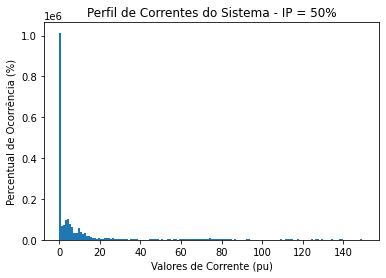

In [ ]:
#Resultados de saída 

(n, bins) = np.histogram([Load_Ia,Load_Ib,Load_Ic],bins=edges)
n
bins
plt.hist(bins[:-1],bins,weights=n)
plt.ylabel('Percentual de Ocorrência (%)')
plt.xlabel('Valores de Corrente (pu)')
plt.title('Perfil de Correntes do Sistema - IP = 50%')
#h=histogram([Load_Va;Load_Vb;Load_Vc],'Normalization','probability');
#title('Perfil de Tensão do Sistema - IP = 50%');
#xlabel('Valores de Tensão (pu)');
#ylabel('Percentual de Ocorrência (%)')

Text(0, 0.5, 'Distância Euclidiana de Corrente (pu)')

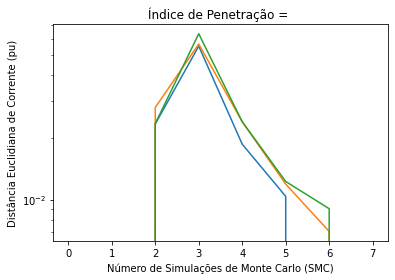

In [ ]:
#figure(2);
plt.semilogy(erroa);
plt.semilogy(errob);
plt.semilogy(erroc);
plt.title('Índice de Penetração = ');
plt.xlabel('Número de Simulações de Monte Carlo (SMC)');
plt.ylabel('Distância Euclidiana de Corrente (pu)')

Text(0, 0.5, 'Percentual de Transgressão de Corrente(%)')

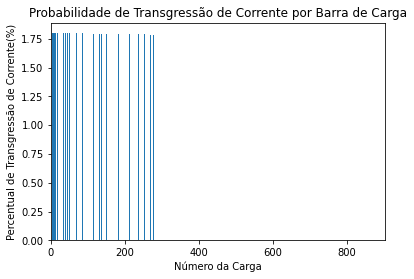

In [ ]:
#figure(3);
#A=np.arange(0,Nb_line,1)
plt.bar(A,Prob_Transg)
plt.xlim((0, Nb_line))
plt.title('Probabilidade de Transgressão de Corrente por Barra de Carga')
plt.xlabel('Número da Carga')
plt.ylabel('Percentual de Transgressão de Corrente(%)')

Text(0, 0.5, 'Quantidade de Transgressão de Corrente')

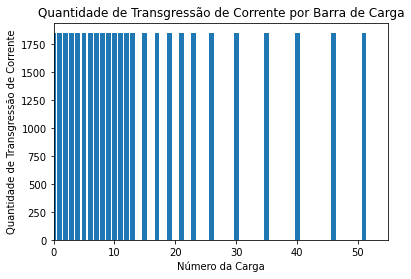

In [ ]:
#figure(4)
plt.bar(A,Nb_Transg)
plt.xlim((0, Nb_Load))
plt.title('Quantidade de Transgressão de Corrente por Barra de Carga')
plt.xlabel('Número da Carga')
plt.ylabel('Quantidade de Transgressão de Corrente')

# Rascunho

In [ ]:
#clear_sky_data = pd.DataFrame(S['clear_sky'])
#clear_sky_data

def Perfil_Irradiacao_Solar(t0, tf, Nb_ss, Nb_PV, ss_res):
    
    drive.mount('/folders/1-df-MbTcGiYYEVIcfMAZjUEMF2cAroZr')
    Sky=scipy.io.loadmat('/folders/1-df-MbTcGiYYEVIcfMAZjUEMF2cAroZr/clear_sky.mat')
    modelos_mensais = scipy.io.loadmat('/folders/1-df-MbTcGiYYEVIcfMAZjUEMF2cAroZr/modelos_mensais_PETR.mat')
    serie_historica = scipy.io.loadmat('/folders/1-df-MbTcGiYYEVIcfMAZjUEMF2cAroZr/serie_historica_PETR.mat')

   
    clear_sky_data = pd.DataFrame(Sky['clear_sky'])
    #modelos_mensais_PETR = #?????
    #serie_historica_PETR = #?????????

#r_cap.at[3,"resid_cap_vals"]
r_cap = r_cap.drop([0])
r_cap[0] = pd.to_numeric(r_cap[0])
r_cap
   
   t = [t0+1:1:tf+1]
  
  return()

function [G] = Perfil_Irradiacao_Solar(t0, tf, Nb_ss, Nb_PV, ss_res);
    
    t = [t0+1:1:tf+1];
    %mes = randi([1 12],1,1);
    mes = 1;
    td = [t0:ss_res/60:tf];
    
    
    cs = clear_sky(t,mes);

    t1 = find(td==t0);
    t2 = find(td==tf);

    irrad_ceu_limpo = spline(t,cs,td(t1:t2));

    for i=1:1:length(irrad_ceu_limpo)
        if irrad_ceu_limpo(i)<=0
            irrad_ceu_limpo(i)=0;
        end
    end
       
    irradiacao = [1 Nb_ss];

    for j=1:1:Nb_PV
        for i=1:1:Nb_ss
        sorteio = random('beta',a_Beta(mes),b_Beta(mes));
        ceu = irrad_ceu_limpo(1,i);
        irradiacao(j,i) = ceu*sorteio;
        end
    end
    
    G = irradiacao;
    
   %Figure = figure(5);
    
    %x0=t0:td:tf;
    %dado = g_global(1,:,1);
    %sol = g_global(:,:,1);
    %serie = plot(x0,dado,'y','Marker','o');
    
    %hold on
    
    %plot(x0,sol,'y','Marker','o');
    
    %hold on
    
    
    %for i=1:1:Nb_ss
    %sorteio = random('beta',a_Beta(mes),b_Beta(mes));
    %ceu = irrad_ceu_limpo(1,i);
    %irradiacao(1,i) = ceu*sorteio;
    %end
    
    %irradiacao1 =  irradiacao; 
    %serie1 = plot(x,irradiacao1,'g','Marker','x')
    
    %hold on
    
     %   for i=1:1:Nb_ss
      %  sorteio = random('beta',a_Beta(mes),b_Beta(mes));
       % ceu = irrad_ceu_limpo(1,i);
        %irradiacao(1,i) = ceu*sorteio;
        %end

        %irradiacao2 = irradiacao;
        %serie2 = plot(irradiacao2,'r','Marker','o');
 
%xlim([0 23])
%title('Séries Sintéticas para o mês de Janeiro geradas a partir dos modelos mensais')
%legend([serie serie1 serie2], {'Séries Históricas', 'Serie Sintética 1', 'Série Sintética 2'}, 'Location', 'bestoutside')
%xlabel('Hora do dia (h)')
%ylabel('Irradiação (W/m^{2})')
